# **Modèle de Popularité**

## **Imports et Dataframe**

In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

import os

import sklearn

from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, learning_curve, KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, OneHotEncoder, StandardScaler, RobustScaler, FunctionTransformer, MinMaxScaler, PolynomialFeatures, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, ConfusionMatrixDisplay, classification_report, f1_score, confusion_matrix

from xgboost import XGBRegressor

from joblib import dump
from joblib import load

In [168]:
pd.options.display.max_columns = None
pd.options.display.max_rows = 200

In [169]:
the_dfs = []

df = pd.read_csv('../data/data_110k_lignes.csv')

the_dfs.append(pd.read_csv('../data/tracks_60k_2022.csv'))
the_dfs.append(pd.read_csv('../data/data_600k_genre.csv'))

df.shape

(110158, 33)

In [170]:
# df = pd.read_csv('../data/data_cleans.csv')

# df.head(10)

In [171]:
df

,Unnamed: 0,artist_name,album_name,album_id,track_name,track_id,popularity,release_date,duration_ms,explicit,external_urls,is_local,preview_url,track_number,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms.1,time_signature
0,0,Gen Hoshino,Comedy,41ERrwfzos93Xlf6hFBiDn,Comedy,5SuOikwiRyPMVoIQDJUgSV,66,2022-04-08,230666,False,https://open.spotify.com/track/5SuOikwiRyPMVoI...,False,https://p.scdn.co/mp3-preview/56ee6d51af5c3a28...,1,acoustic,0.676,0.461,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,audio_features,5SuOikwiRyPMVoIQDJUgSV,spotify:track:5SuOikwiRyPMVoIQDJUgSV,https://api.spotify.com/v1/tracks/5SuOikwiRyPM...,https://api.spotify.com/v1/audio-analysis/5SuO...,230667,4
1,1,Ray LaMontagne,I Was Born To Love You,7cwHkTgTHLbCUFB6hRi9QQ,I Was Born To Love You,3PG6V5yuFfo4APiovOQoRv,64,2022-04-08,265843,False,https://open.spotify.com/track/3PG6V5yuFfo4APi...,False,https://p.scdn.co/mp3-preview/46ff8588929ba7bd...,1,acoustic,0.650,0.271,9,-11.081,1,0.0314,0.7940,0.000069,0.1960,0.2100,78.036,audio_features,3PG6V5yuFfo4APiovOQoRv,spotify:track:3PG6V5yuFfo4APiovOQoRv,https://api.spotify.com/v1/tracks/3PG6V5yuFfo4...,https://api.spotify.com/v1/audio-analysis/3PG6...,265843,4
2,2,Steve Moakler,Make A Little Room,457Ok9pnF5fAfG7lNUFqHS,Make A Little Room,62yXckrKNy9Sylka6oifst,53,2022-08-12,180493,False,https://open.spotify.com/track/62yXckrKNy9Sylk...,False,https://p.scdn.co/mp3-preview/5dcabbd94b669a08...,1,acoustic,0.758,0.722,1,-6.252,1,0.0511,0.1650,0.000006,0.1060,0.6600,146.031,audio_features,62yXckrKNy9Sylka6oifst,spotify:track:62yXckrKNy9Sylka6oifst,https://api.spotify.com/v1/tracks/62yXckrKNy9S...,https://api.spotify.com/v1/audio-analysis/62yX...,180493,4
3,3,Ben Rector,The Joy of Music,1l4VD485oDSJM23eWJEWJN,Steady Love,6UOkF086zUgYXnqFxqUvEI,55,2022-03-11,224333,False,https://open.spotify.com/track/6UOkF086zUgYXnq...,False,https://p.scdn.co/mp3-preview/173b473ca21bbc2c...,4,acoustic,0.678,0.277,11,-10.537,1,0.0602,0.8430,0.000004,0.1040,0.2380,76.935,audio_features,6UOkF086zUgYXnqFxqUvEI,spotify:track:6UOkF086zUgYXnqFxqUvEI,https://api.spotify.com/v1/tracks/6UOkF086zUgY...,https://api.spotify.com/v1/audio-analysis/6UOk...,224333,4
4,4,Ben Rector,The Joy of Music,1l4VD485oDSJM23eWJEWJN,Living My Best Life,0R7EWhquaAICmyE5MZqt3q,54,2022-03-11,215213,False,https://open.spotify.com/track/0R7EWhquaAICmyE...,False,https://p.scdn.co/mp3-preview/697c72a3a0750cd9...,3,acoustic,0.566,0.733,4,-5.302,1,0.0699,0.0830,0.000002,0.3620,0.6360,178.828,audio_features,0R7EWhquaAICmyE5MZqt3q,spotify:track:0R7EWhquaAICmyE5MZqt3q,https://api.spotify.com/v1/tracks/0R7EWhquaAIC...,https://api.spotify.com/v1/audio-analysis/0R7E...,215213,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110153,110153,Chris Tomlin,Today's Worship Hits 2022,6QqOjkKHOl1x0WAAOI2EXT,Holy Forever,7eh4rgLpOJALudfzgA3FR4,3,2022-07-29,308066,False,https://open.spotify.com/track/7eh4rgLpOJALudf...,False,https://p.scdn.co/mp3-preview/fc308a7c4a0e15cd...,42,world-music,0.453,0.704,1,-4.620,1,0.0351,0.2260,0.000000,0.1180,0.2710,144.004,audio_features,7eh4rgLpOJALudfzgA3FR4,spotify:track:7eh4rgLpOJALudfzgA3FR4,https://api.spotify.com/v1/tracks/7eh4rgLpOJAL...,https://api.spotify.com/v1/audio-analysis/7eh4...,308067,4
110154,110154,Chris Tomlin,Top 100 Christian Songs,3QQFxmXILFHkXKvU4jLKKn,I See You,1G3kSoHLjchF3Rkmrnqolm,5,2022-02-28,230673,False,https://open.spotify.com/track/1G3kSoHLjchF3Rk...,False,https://p.scdn.co/mp3-preview/bd694731552be6d4...,57,world-music,0.431,0.734,1,-4.561,1,0.0383,0.1210,0.000000,0.1040,0.3630,159.974,audio_features,1G3kSoHLjchF3Rkmrnqolm,spotify:track:1G3kSoHLjchF3Rkmrnqolm,https://api.spotify.com/v1/tracks/1G3kSoHLjchF...,https://api.spotify.com/v1/audio-analysis/1G3k...,230673,4
110155,110155,Passion,Top 100 Christian Songs,3QQFxmXILFHkX

In [172]:
def groupby_track_id (df):

    last_col = ["track_name", "track_id", "genre"]
    mean_col = ["popularity", "duration_ms", "explicit", "track_number", "danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "time_signature"    ]
    sum_col = df.drop(last_col + mean_col,axis=1).columns

    dict_agg = {}

    for col in last_col:
        dict_agg[f'{col}'] = 'last'

    for col in mean_col:
        dict_agg[f'{col}'] = 'mean'

    for col in sum_col:
        dict_agg[f'{col}'] = "sum"

    df = df.groupby('track_id').agg(dict_agg)
    del df['track_id']
    df = df.reset_index()

    return df

In [173]:
def clean_data(df):
    
    try:
        del df['Unnamed: 0']
    except:
        print('Pas de colonne : "Unnamed: 0"')


    df = df[df[['genre', 'track_id']].duplicated() == False]
    df.drop(df.select_dtypes('object').drop(['genre','release_date'], axis=1).columns, axis=1, inplace=True)
    
    try:
        df['explicit'] = df['explicit'].apply(lambda x : 1 if x == True else 0)
    except:
        df['explicit'] = 2

    df.drop(df[df['track_number'] > 100].index, axis=0, inplace=True)

    try:
        del df['is_local']
    except:
        print('Pas de colonne : is_local')
        
    try:
        del df['duration_ms.1']
    except:
        print('Pas de colonne : duration_ms.1')

    df = df.dropna(axis=0)
    df = df.drop_duplicates()
    try:
        df.drop(df[df['track_number'] > 100].index, axis=0, inplace=True)
    except:
        print('Pas de colonne : "track_number"')

    df['release_date'] = df['release_date'].apply(lambda x : x[:4])
    df['release_date'] = df['release_date'].apply(lambda x : int(x))

        
    df = pd.get_dummies(df, columns=['genre'], sparse=False, prefix=None)

    df['popularity'] = df['popularity'].apply(lambda x : int(x))

    return df

In [174]:

def merge_dfs(df_clean, df_merge):

    try:
        if df_merge['explicit'][0] == False or df_merge['explicit'][0] == True:
            df_merge['explicit'] = df_merge['explicit'].apply(lambda x : 0 if x == False else 1)
    except:
        print('Pas de colonne : "explicit"')

    df = pd.concat([df_clean, df_merge])

    try:
        df.drop(df[df['track_number'] > 100].index, axis=0, inplace=True)
    except:
        print('Pas de colonne : "track_number"')

    df = df[df_clean.columns]

    df = groupby_track_id(df).reset_index()

    try:
        del df['Unnamed: 0']
    except:
        print('Pas de colonne : "Unnamed: 0"')

    try:
        del df['index']
    except:
        print('Pas de colonne : "index"')

    return df

In [175]:
# for the_df in the_dfs:
#     df = merge_dfs(df, the_df)

In [176]:
df = clean_data(df)

/tmp/ipykernel_298873/2464669992.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(df.select_dtypes('object').drop(['genre','release_date'], axis=1).columns, axis=1, inplace=True)
/tmp/ipykernel_298873/2464669992.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['explicit'] = df['explicit'].apply(lambda x : 1 if x == True else 0)
/tmp/ipykernel_298873/2464669992.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

In [177]:
df

,popularity,release_date,duration_ms,explicit,track_number,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,genre_acoustic,genre_afrobeat,genre_alt-rock,genre_alternative,genre_ambient,genre_anime,genre_black-metal,genre_bluegrass,genre_blues,genre_brazil,genre_breakbeat,genre_british,genre_cantopop,genre_chicago-house,genre_children,genre_chill,genre_classical,genre_club,genre_comedy,genre_country,genre_dance,genre_dancehall,genre_death-metal,genre_deep-house,genre_detroit-techno,genre_disco,genre_drum-and-bass,genre_dub,genre_dubstep,genre_edm,genre_electro,genre_electronic,genre_emo,genre_folk,genre_forro,genre_french,genre_funk,genre_garage,genre_german,genre_gospel,genre_goth,genre_grindcore,genre_groove,genre_grunge,genre_guitar,genre_happy,genre_hard-rock,genre_hardcore,genre_hardstyle,genre_heavy-metal,genre_hip-hop,genre_honky-tonk,genre_house,genre_idm,genre_indian,genre_indie,genre_indie-pop,genre_industrial,genre_iranian,genre_j-dance,genre_j-idol,genre_j-pop,genre_j-rock,genre_jazz,genre_k-pop,genre_kids,genre_latin,genre_latino,genre_malay,genre_mandopop,genre_metal,genre_metalcore,genre_minimal-techno,genre_mpb,genre_new-age,genre_opera,genre_pagode,genre_party,genre_piano,genre_pop,genre_pop-film,genre_power-pop,genre_progressive-house,genre_psych-rock,genre_punk,genre_punk-rock,genre_r-n-b,genre_reggae,genre_reggaeton,genre_rock,genre_rock-n-roll,genre_rockabilly,genre_romance,genre_sad,genre_salsa,genre_samba,genre_sertanejo,genre_show-tunes,genre_singer-songwriter,genre_ska,genre_sleep,genre_songwriter,genre_soul,genre_spanish,genre_study,genre_swedish,genre_synth-pop,genre_tango,genre_techno,genre_trance,genre_trip-hop,genre_turkish,genre_world-music
0,66,2022,230666,0,1,0.676,0.461,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,64,2022,265843,0,1,0.650,0.271,9,-11.081,1,0.0314,0.7940,0.000069,0.1960,0.2100,78.036,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,53,2022,180493,0,1,0.758,0.722,1,-6.252,1,0.0511,0.1650,0.000006,0.1060,0.6600,146.031,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,55,2022,224333,0,4,0.678,0.277,11,-10.537,1,0.0602,0.8430,0.000004,0.1040,0.2380,76.935,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,54,2022,215213,0,3,0.566,0.733,4,-5.302,1,0.0699,0.0830,0.000002,0.3620,0.6360,178.828,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110153,3,2022,308066,0,42,0.453,0.704,1,-4.620,1,0.0351,0.2260,0.000000,0.1180,0.2710,144.004,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [178]:
df[df.popularity > 50].popularity.value_counts().sum()

16211

In [179]:
# plt.figure(figsize=(12,20))
# sns.boxplot(x=df['genre'], y=df['popularity'])

# plt.show()

## **Découpage du dataset**

In [180]:
X = df.drop('popularity', axis=1)
y = df['popularity']

In [181]:
the_X_train, the_X_test, the_y_train, the_y_test = train_test_split(X, y, shuffle=True, train_size=0.95, random_state=42)

In [182]:
X_train, X_test, y_train, y_test = train_test_split(the_X_train, the_y_train, shuffle=True, train_size=0.80, random_state=42)

In [183]:
dummy = DummyRegressor()

dummy.fit(X_train, y_train)
dummy.score(X_test, y_test)

-0.0001278259398242998

## **Premier Modèle**

In [184]:
cat_columns = ["key"]
num_columns = df.select_dtypes('number').drop(cat_columns, axis=1)

std = MinMaxScaler()
# ohe = OneHotEncoder(handle_unknown="ignore",sparse_output=False)
ohe = OrdinalEncoder()

encoder = ColumnTransformer(
    transformers=[
        ('ohe', ohe, cat_columns)
    ],
    n_jobs=-1,
    remainder='passthrough'
)

In [185]:
models = [Lasso(), Ridge(), ElasticNet()]

In [186]:
list_models = []
dict_models_fit = {}

for model in models:
    pipe = Pipeline([
        ('enc', encoder),
        ("std",std),
        ('poly', PolynomialFeatures(1)), 
        ('model', model),
    ])

    the_model = pipe.fit(X_train, y_train)
    dict_models_fit[f'{model.__class__.__name__}'] = the_model

    score = pipe.score(X_test, y_test)
    score = round(score,4)

    prediction = pipe.predict(X_test)
    score_rmse = math.sqrt(mean_squared_error(y_test, prediction))
    score_mae = mean_absolute_error(y_test, prediction)

    list_models.append([f"{model.__class__.__name__}", f"{round(score *100, 2)}%", f"{round(score_rmse,2)}"])
    
    print(f"Nom du modèle : {model.__class__.__name__}, R2 score : {round(score *100, 2)}%, RMSE score : {round(score_rmse,2)}, MAE : {round(score_mae,2)}")

Nom du modèle : Lasso, R2 score : 1.49%, RMSE score : 18.2, MAE : 15.04
Nom du modèle : Ridge, R2 score : 71.35%, RMSE score : 9.82, MAE : 7.57
Nom du modèle : ElasticNet, R2 score : 1.5%, RMSE score : 18.2, MAE : 15.04


In [187]:
df_list_models = pd.DataFrame(list_models,columns=['modele', "r2_score", "score_rmse"])

df_list_models.sort_values('r2_score', ascending=False)

,modele,r2_score,score_rmse
1,Ridge,71.35%,9.82
2,ElasticNet,1.5%,18.2
0,Lasso,1.49%,18.2


## **Évaluation**

In [188]:
model_entraines = []

In [189]:
def evaluation_ln(model):

    model.fit(X_train,y_train)
    prediction = model.predict(X_test)

    name = model.named_steps.model.__class__.__name__

    score = model.score(X_test, y_test)
    score = round(score,4)

    prediction = model.predict(X_test)
    score_rmse = math.sqrt(mean_squared_error(y_test, prediction))
    score_mae = mean_absolute_error(y_test, prediction)

    list_models.append([f"{name}", f"{round(score *100, 2)}%", f"{round(score_rmse,2)}"])
    
    print(f"Nom du modèle : {name}, R2 score : {round(score *100, 2)}%, RMSE score : {round(score_rmse,2)}, MAE : {round(score_mae,2)}")

    N, train_score, val_score = learning_curve(model, X_train, y_train,
                                                n_jobs=-1,
                                                cv = 4, scoring='r2',
                                                train_sizes=np.linspace(0.1,1,10))
                                            
    model_entraines.append({'nom' : name, 'model': model, 'r2' : score})

    plt.figure(figsize=(12,8))
    plt.plot(N, train_score.mean(axis=1), label='Train Score')
    plt.plot(N, val_score.mean(axis=1), label='Validation Score')
    plt.legend()
    plt.show()

In [190]:
def evaluation(model):

    model.fit(X_train,y_train)
    prediction = model.predict(X_test)

    name = model.named_steps.model.__class__.__name__

    score = model.score(X_test, y_test)
    score = round(score,4)

    prediction = model.predict(X_test)
    score_rmse = math.sqrt(mean_squared_error(y_test, prediction))
    score_mae = mean_absolute_error(y_test, prediction)

    list_models.append([f"{model.__class__.__name__}", f"{round(score *100, 2)}%", f"{round(score_rmse,2)}"])
    
    print(f"Nom du modèle : {name}, R2 score : {round(score *100, 2)}%, RMSE score : {round(score_rmse,2)}, MAE : {round(score_mae,2)}")

## **XgBoost**

Nom du modèle : XGBRegressor, R2 score : 72.73%, RMSE score : 9.58, MAE : 7.38


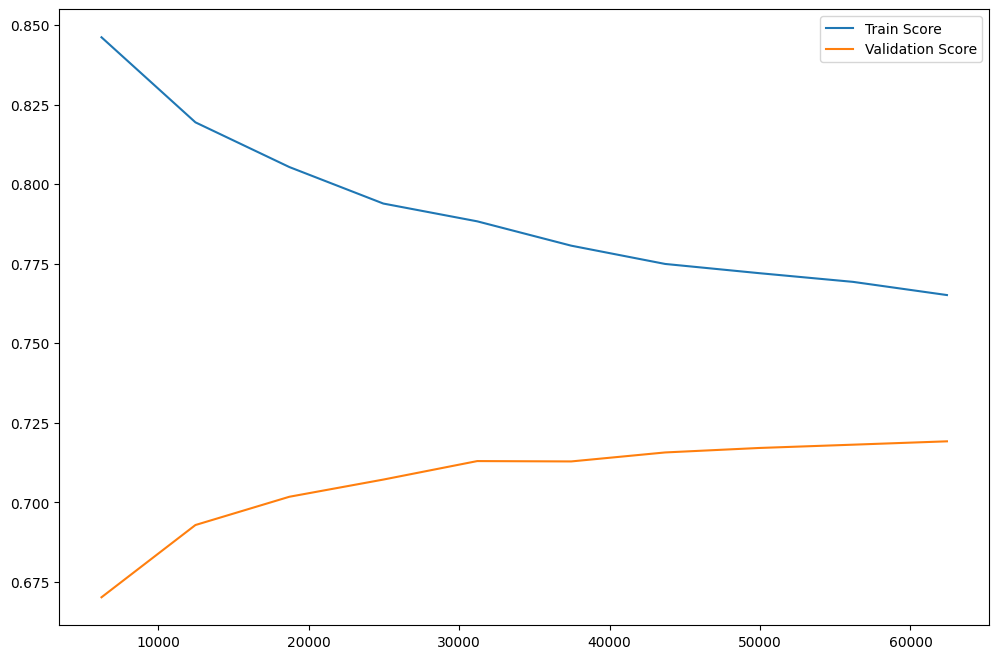

In [191]:
pipe = Pipeline([
    ('enc', encoder),
    ('std', std),
    ('poly', PolynomialFeatures(1)), 
    ('model', XGBRegressor(random_state=42, tree_method="hist", n_jobs=-1, learning_rate= 0.25)),
])

evaluation_ln(pipe)

In [192]:
# for i in range(0, 3):
#     pipe = Pipeline([
#         ('enc', encoder),
#         ('poly', PolynomialFeatures(i)), 
#         ('model', XGBRegressor(random_state=42, tree_method="hist", n_jobs=-1, learning_rate= 0.25)),
#     ])

#     print('Range :', i)
#     evaluation(pipe)

## **RandomizedSearchCV**

In [193]:
pipe = Pipeline([
    ('enc', encoder),
    ('std', std),
    ('model', XGBRegressor(random_state=42, tree_method="hist", n_jobs=-1, learning_rate= 0.25)),
])

param_grid = {
    'model__max_depth': [5, 10, 15, None],
    'model__learning_rate': list(np.linspace(0.1, 0.5, 6)),
    'model__n_estimators': list(range(40, 210, 10)),
    'model__gamma': list(np.linspace(0, 1, 5)) + [None],
}

grid = RandomizedSearchCV(pipe, param_grid, cv=4, scoring='r2', n_jobs=-1, verbose=3)

grid.fit(X_train, y_train)

score = grid.best_score_
score = round(score,4)

params = grid.best_params_

print(f"Meilleur score : {round(score * 100, 2)}% \nMeilleurs paramètres : {params}")

Fitting 4 folds for each of 10 candidates, totalling 40 fits
[CV 4/4] END model__gamma=0.75, model__learning_rate=0.5, model__max_depth=5, model__n_estimators=110;, score=0.733 total time=   3.4s
[CV 2/4] END model__gamma=0.75, model__learning_rate=0.5, model__max_depth=5, model__n_estimators=110;, score=0.731 total time=   3.6s
[CV 3/4] END model__gamma=0.75, model__learning_rate=0.5, model__max_depth=5, model__n_estimators=110;, score=0.727 total time=   3.8s
[CV 1/4] END model__gamma=0.75, model__learning_rate=0.5, model__max_depth=5, model__n_estimators=110;, score=0.731 total time=   3.9s
[CV 1/4] END model__gamma=0.5, model__learning_rate=0.26, model__max_depth=5, model__n_estimators=100;, score=0.710 total time=   3.2s
[CV 2/4] END model__gamma=0.5, model__learning_rate=0.26, model__max_depth=5, model__n_estimators=100;, score=0.714 total time=   3.3s
[CV 3/4] END model__gamma=0.5, model__learning_rate=0.26, model__max_depth=5, model__n_estimators=100;, score=0.709 total time=  

Meilleur score : 77.2% 
Meilleurs paramètres : {'model__n_estimators': 140, 'model__max_depth': 5, 'model__learning_rate': 0.42000000000000004, 'model__gamma': 1.0}

## **GridSearchCV**

In [194]:
pipe = Pipeline([
    ('enc', encoder),
    ('std', std),
    ('model', XGBRegressor(random_state=42, max_depth=10, tree_method="hist", n_jobs=-1, learning_rate= 0.25)),
])

param_grid = {
    'model__learning_rate': list(np.linspace(0.1, 0.3, 4)),
    'model__n_estimators': list(range(160, 260, 10)),
    'model__gamma': list(np.linspace(0, 1, 5)) + [None],
}

grid = GridSearchCV(pipe, param_grid, cv=4, scoring='r2', n_jobs=-1, verbose=3)

grid.fit(X_train, y_train)

score = grid.best_score_
score = round(score,4)

params = grid.best_params_

best_model = grid.best_estimator_

print(f"Meilleur score : {round(score * 100, 2)}% \nMeilleurs paramètres : {params}")

Fitting 4 folds for each of 240 candidates, totalling 960 fits
[CV 1/4] END model__gamma=0.0, model__learning_rate=0.1, model__n_estimators=160;, score=0.726 total time=   9.3s
[CV 3/4] END model__gamma=0.0, model__learning_rate=0.1, model__n_estimators=160;, score=0.722 total time=   9.5s
[CV 2/4] END model__gamma=0.0, model__learning_rate=0.1, model__n_estimators=160;, score=0.726 total time=   9.6s
[CV 4/4] END model__gamma=0.0, model__learning_rate=0.1, model__n_estimators=160;, score=0.724 total time=   9.9s
[CV 3/4] END model__gamma=0.0, model__learning_rate=0.1, model__n_estimators=170;, score=0.724 total time=  10.6s
[CV 4/4] END model__gamma=0.0, model__learning_rate=0.1, model__n_estimators=170;, score=0.726 total time=  10.6s
[CV 2/4] END model__gamma=0.0, model__learning_rate=0.1, model__n_estimators=170;, score=0.729 total time=  10.7s
[CV 1/4] END model__gamma=0.0, model__learning_rate=0.1, model__n_estimators=170;, score=0.728 total time=  10.9s
[CV 1/4] END model__gamma

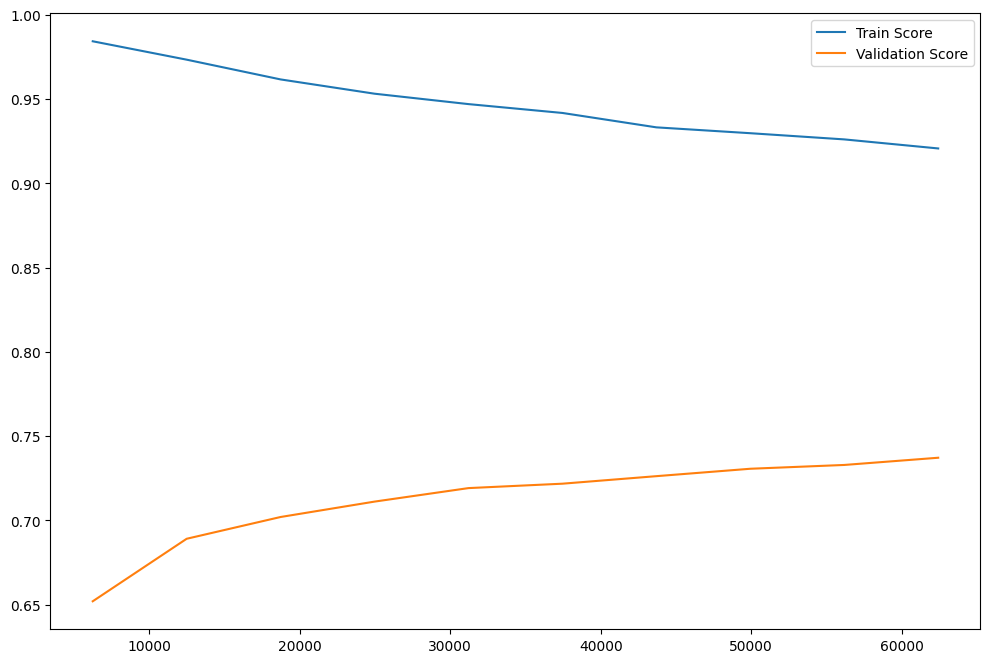

In [195]:
N, train_score, val_score = learning_curve(best_model, X_train, y_train,
                                            n_jobs=-1,
                                            cv = 4, scoring='r2',
                                            train_sizes=np.linspace(0.1,1,10))

plt.figure(figsize=(12,8))
plt.plot(N, train_score.mean(axis=1), label='Train Score')
plt.plot(N, val_score.mean(axis=1), label='Validation Score')
plt.legend()
plt.show()

## **Test Final**

In [196]:
name = best_model[-1].__class__.__name__

score = best_model.score(X_test, y_test)
score = round(score,4)

prediction = best_model.predict(X_test)
score_rmse = math.sqrt(mean_squared_error(y_test, prediction))
score_mae = mean_absolute_error(y_test, prediction)

print(f"Nom du modèle : {name}, R2 score : {round(score *100, 2)}%, RMSE score : {round(score_rmse,2)}, MAE : {round(score_mae,2)}")

Nom du modèle : XGBRegressor, R2 score : 74.9%, RMSE score : 9.19, MAE : 6.93


In [197]:
name = best_model[-1].__class__.__name__

score = best_model.score(the_X_test, the_y_test)
score = round(score,4)

prediction = best_model.predict(the_X_test)
score_rmse = math.sqrt(mean_squared_error(the_y_test, prediction))
score_mae = mean_absolute_error(the_y_test, prediction)

print(f"Nom du modèle : {name}, R2 score : {round(score *100, 2)}%, RMSE score : {round(score_rmse,2)}, MAE : {round(score_mae,2)}")

Nom du modèle : XGBRegressor, R2 score : 74.6%, RMSE score : 9.25, MAE : 7.01


## **Dump**

In [198]:
pipe.fit(X, y)
pipe.score(X, y)

0.8512542231978577

In [199]:
dump(pipe, f"models/{pipe.named_steps.model.__class__.__name__}_pop.pkl")

['models/XGBRegressor_pop.pkl']

## **MLFlow**

In [200]:
import mlflow

In [201]:
experiment_name = "Brief"

In [202]:
try:
    experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id
except AttributeError:
    experiment_id = mlflow.create_experiment(experiment_name)

eval_data = X_test
eval_data["label"] = y_test

with mlflow.start_run(experiment_id=experiment_id, nested=True, run_name=best_model[-1].__class__.__name__):
    mlflow.log_params(best_model[-1].get_params())
    mlflow.sklearn.log_model(best_model, experiment_name)
    model_uri = mlflow.get_artifact_uri(experiment_name)

    result = mlflow.evaluate(
            model_uri,
            eval_data,
            targets="label",
            model_type="regressor",
            evaluators=["default"],
    )

2023/03/02 20:45:23 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2023/03/02 20:45:24 INFO mlflow.models.evaluation.default_evaluator: Shap explainer Permutation is used.
Permutation explainer: 2001it [12:43,  2.59it/s]                          
Unable to serialize underlying model using MLflow, will use SHAP serialization
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
